In [2]:
import glob
import csv
import cv2
import time
import os
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from shapely.geometry import Polygon

In [3]:
import tensorflow as tf

In [18]:
import time
import numpy as np
import threading
import multiprocessing
try:
    import queue
except ImportError:
    import Queue as queue

In [20]:

class GeneratorEnqueuer():
    """Builds a queue out of a data generator.

    Used in `fit_generator`, `evaluate_generator`, `predict_generator`.

    # Arguments
        generator: a generator function which endlessly yields data
        use_multiprocessing: use multiprocessing if True, otherwise threading
        wait_time: time to sleep in-between calls to `put()`
        random_seed: Initial seed for workers,
            will be incremented by one for each workers.
    """

    def __init__(self, 
                 generator,
                 use_multiprocessing=False,
                 wait_time=0.05,
                 random_seed=None):
        self.wait_time = wait_time
        self._generator = generator
        self._use_multiprocessing = use_multiprocessing
        self._threads = []
        self._stop_event = None
        self.queue = None
        self.random_seed = random_seed

    def start(self, workers=1, max_queue_size=10):
        """Kicks off threads which add data from the generator into the queue.

        # Arguments
            workers: number of worker threads
            max_queue_size: queue size
                (when full, threads could block on `put()`)
        """

        def data_generator_task():
            while not self._stop_event.is_set():
                try:
                    if self._use_multiprocessing or self.queue.qsize() < max_queue_size:
                        generator_output = next(self._generator)
                        self.queue.put(generator_output)
                    else:
                        time.sleep(self.wait_time)
                except Exception:
                    self._stop_event.set()
                    raise

        try:
            if self._use_multiprocessing:
                self.queue = multiprocessing.Queue(maxsize=max_queue_size)
                self._stop_event = multiprocessing.Event()
            else:
                self.queue = queue.Queue()
                self._stop_event = threading.Event()

            for _ in range(workers):
                if self._use_multiprocessing:
                    # Reset random seed else all children processes
                    # share the same seed
                    np.random.seed(self.random_seed)
                    thread = multiprocessing.Process(target=data_generator_task)
                    thread.daemon = True
                    if self.random_seed is not None:
                        self.random_seed += 1
                else:
                    thread = threading.Thread(target=data_generator_task)
                self._threads.append(thread)
                thread.start()
        except:
            self.stop()
            raise

    def is_running(self):
        return self._stop_event is not None and not self._stop_event.is_set()

    def stop(self, timeout=None):
        """Stops running threads and wait for them to exit, if necessary.

        Should be called by the same thread which called `start()`.

        # Arguments
            timeout: maximum time to wait on `thread.join()`.
        """
        if self.is_running():
            self._stop_event.set()

        for thread in self._threads:
            if thread.is_alive():
                if self._use_multiprocessing:
                    thread.terminate()
                else:
                    thread.join(timeout)

        if self._use_multiprocessing:
            if self.queue is not None:
                self.queue.close()

        self._threads = []
        self._stop_event = None
        self.queue = None

    def get(self):
        """Creates a generator to extract data from the queue.

        Skip the data if it is `None`.

        # Returns
            A generator
        """
        while self.is_running():
            if not self.queue.empty():
                inputs = self.queue.get()
                if inputs is not None:
                    yield inputs
            else:
                time.sleep(self.wait_time)

In [4]:
training_data_path = ""
max_image_large_side = 1280
max_text_size = 800
min_text_size = 10
min_crop_side_ratio = 0.1
geometry = "RBOX"

In [30]:
training_data_path = "/home/mageswarand/Downloads/0319updated.task1train(628p)-20190320T064205Z-001/0319updated.task1train(628p)/"
training_data_path = "/opt/data/icdar/2015/train/"

In [33]:
for filename in os.listdir(training_data_path):
    if "jpg" not in filename:
        dst = filename.replace("gt_", "")
        os.rename(training_data_path + filename, training_data_path + dst)

In [62]:
def get_images(training_data_path=training_data_path):
    files = []
    for ext in ['jpg', 'png', 'jpeg', 'JPG']:
        files.extend(glob.glob(
            os.path.join(training_data_path, '*.{}'.format(ext))))
    return files

In [63]:
images = get_images(training_data_path=training_data_path)
image_file_name = images[0]
im = cv2.imread(image_file_name)
# print im_fn
h, w, _ = im.shape
h,w

(720, 1280)

In [64]:
def load_annoataion(p):
    '''
    load annotation from the text file
    :param p:
    :return:
    '''
    text_polys = []
    text_tags = []
    if not os.path.exists(p):
        return np.array(text_polys, dtype=np.float32)
    with open(p, 'r') as f:
        reader = csv.reader(f)
        for line in reader:
            label = line[-1]
            # strip BOM. \ufeff for python3,  \xef\xbb\bf for python2
            line = [i.strip('\ufeff').strip('\xef\xbb\xbf') for i in line]

            x1, y1, x2, y2, x3, y3, x4, y4 = list(map(float, line[:8]))
            text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
            if label == '*' or label == '###':
                text_tags.append(True)
            else:
                text_tags.append(False)
        return np.array(text_polys, dtype=np.float32), np.array(text_tags, dtype=np.bool)


In [128]:
# text_file_name = images[0].replace(os.path.basename(images[0]).split('.')[1], 'txt')
# text_polys, text_tags = load_annoataion(p=text_file_name)

In [66]:
def polygon_area(poly):
    '''
    compute area of a polygon
    :param poly:
    :return:
    '''
    edge = [
        (poly[1][0] - poly[0][0]) * (poly[1][1] + poly[0][1]),
        (poly[2][0] - poly[1][0]) * (poly[2][1] + poly[1][1]),
        (poly[3][0] - poly[2][0]) * (poly[3][1] + poly[2][1]),
        (poly[0][0] - poly[3][0]) * (poly[0][1] + poly[3][1])
    ]
    return np.sum(edge)/2.

In [67]:
def check_and_validate_polys(polys, tags, xxx_todo_changeme):
    '''
    check so that the text poly is in the same direction,
    and also filter some invalid polygons
    :param polys:
    :param tags:
    :return:
    '''
    (h, w) = xxx_todo_changeme
    if polys.shape[0] == 0:
        return polys
    polys[:, :, 0] = np.clip(polys[:, :, 0], 0, w-1)
    polys[:, :, 1] = np.clip(polys[:, :, 1], 0, h-1)

    validated_polys = []
    validated_tags = []
    for poly, tag in zip(polys, tags):
        p_area = polygon_area(poly)
#         print(p_area)
        if abs(p_area) < 1:
            # print poly
            print('invalid poly')
            continue
        if p_area > 0:
            print('poly in wrong direction')
            poly = poly[(0, 3, 2, 1), :]
        validated_polys.append(poly)
        validated_tags.append(tag)
    return np.array(validated_polys), np.array(validated_tags)

In [127]:
# text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))
# text_polys, text_tags

In [69]:
def crop_area(im, polys, tags, min_crop_side_ratio=min_crop_side_ratio, crop_background=False, max_tries=50):
    '''
    make random crop from the input image
    :param im:
    :param polys:
    :param tags:
    :param crop_background:
    :param max_tries:
    :return:
    '''
    h, w, _ = im.shape
    pad_h = h//10
    pad_w = w//10
    h_array = np.zeros((h + pad_h*2), dtype=np.int32)
    w_array = np.zeros((w + pad_w*2), dtype=np.int32)
    for poly in polys:
        poly = np.round(poly, decimals=0).astype(np.int32)
        minx = np.min(poly[:, 0])
        maxx = np.max(poly[:, 0])
        w_array[minx+pad_w:maxx+pad_w] = 1
        miny = np.min(poly[:, 1])
        maxy = np.max(poly[:, 1])
        h_array[miny+pad_h:maxy+pad_h] = 1
    # ensure the cropped area not across a text
    h_axis = np.where(h_array == 0)[0]
    w_axis = np.where(w_array == 0)[0]
    if len(h_axis) == 0 or len(w_axis) == 0:
        return im, polys, tags
    for i in range(max_tries):
        xx = np.random.choice(w_axis, size=2)
        xmin = np.min(xx) - pad_w
        xmax = np.max(xx) - pad_w
        xmin = np.clip(xmin, 0, w-1)
        xmax = np.clip(xmax, 0, w-1)
        yy = np.random.choice(h_axis, size=2)
        ymin = np.min(yy) - pad_h
        ymax = np.max(yy) - pad_h
        ymin = np.clip(ymin, 0, h-1)
        ymax = np.clip(ymax, 0, h-1)
        if xmax - xmin < min_crop_side_ratio*w or ymax - ymin < min_crop_side_ratio*h:
            # area too small
            continue
        if polys.shape[0] != 0:
            poly_axis_in_area = (polys[:, :, 0] >= xmin) & (polys[:, :, 0] <= xmax) \
                                & (polys[:, :, 1] >= ymin) & (polys[:, :, 1] <= ymax)
            selected_polys = np.where(np.sum(poly_axis_in_area, axis=1) == 4)[0]
        else:
            selected_polys = []
        if len(selected_polys) == 0:
            # no text in this area
            if crop_background:
                return im[ymin:ymax+1, xmin:xmax+1, :], polys[selected_polys], tags[selected_polys]
            else:
                continue
        im = im[ymin:ymax+1, xmin:xmax+1, :]
        polys = polys[selected_polys]
        tags = tags[selected_polys]
        polys[:, :, 0] -= xmin
        polys[:, :, 1] -= ymin
        return im, polys, tags

    return im, polys, tags


In [70]:

def shrink_poly(poly, r):
    '''
    fit a poly inside the origin poly, maybe bugs here...
    used for generate the score map
    :param poly: the text poly
    :param r: r in the paper
    :return: the shrinked poly
    '''
    # shrink ratio
    R = 0.3
    # find the longer pair
    if np.linalg.norm(poly[0] - poly[1]) + np.linalg.norm(poly[2] - poly[3]) > \
                    np.linalg.norm(poly[0] - poly[3]) + np.linalg.norm(poly[1] - poly[2]):
        # first move (p0, p1), (p2, p3), then (p0, p3), (p1, p2)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
        ## p0, p3
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
    else:
        ## p0, p3
        # print poly
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
    return poly


In [71]:



def point_dist_to_line(p1, p2, p3):
    # compute the distance from p3 to p1-p2
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)


def fit_line(p1, p2):
    # fit a line ax+by+c = 0
    if p1[0] == p1[1]:
        return [1., 0., -p1[0]]
    else:
        [k, b] = np.polyfit(p1, p2, deg=1)
        return [k, -1., b]


def line_cross_point(line1, line2):
    # line1 0= ax+by+c, compute the cross point of line1 and line2
    if line1[0] != 0 and line1[0] == line2[0]:
        print('Cross point does not exist')
        return None
    if line1[0] == 0 and line2[0] == 0:
        print('Cross point does not exist')
        return None
    if line1[1] == 0:
        x = -line1[2]
        y = line2[0] * x + line2[2]
    elif line2[1] == 0:
        x = -line2[2]
        y = line1[0] * x + line1[2]
    else:
        k1, _, b1 = line1
        k2, _, b2 = line2
        x = -(b1-b2)/(k1-k2)
        y = k1*x + b1
    return np.array([x, y], dtype=np.float32)


def line_verticle(line, point):
    # get the verticle line from line across point
    if line[1] == 0:
        verticle = [0, -1, point[1]]
    else:
        if line[0] == 0:
            verticle = [1, 0, -point[0]]
        else:
            verticle = [-1./line[0], -1, point[1] - (-1/line[0] * point[0])]
    return verticle

In [72]:



def rectangle_from_parallelogram(poly):
    '''
    fit a rectangle from a parallelogram
    :param poly:
    :return:
    '''
    p0, p1, p2, p3 = poly
    angle_p0 = np.arccos(np.dot(p1-p0, p3-p0)/(np.linalg.norm(p0-p1) * np.linalg.norm(p3-p0)))
    if angle_p0 < 0.5 * np.pi:
        if np.linalg.norm(p0 - p1) > np.linalg.norm(p0-p3):
            # p0 and p2
            ## p0
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p0)

            new_p3 = line_cross_point(p2p3, p2p3_verticle)
            ## p2
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p2)

            new_p1 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
        else:
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p0)

            new_p1 = line_cross_point(p1p2, p1p2_verticle)
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p2)

            new_p3 = line_cross_point(p0p3, p0p3_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
    else:
        if np.linalg.norm(p0-p1) > np.linalg.norm(p0-p3):
            # p1 and p3
            ## p1
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p1)

            new_p2 = line_cross_point(p2p3, p2p3_verticle)
            ## p3
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p3)

            new_p0 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)
        else:
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p1)

            new_p0 = line_cross_point(p0p3, p0p3_verticle)
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p3)

            new_p2 = line_cross_point(p1p2, p1p2_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)

In [73]:



def sort_rectangle(poly):
    # sort the four coordinates of the polygon, points in poly should be sorted clockwise
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # 底边平行于X轴, 那么p0为左上角 - if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
    else:
        # 找到最低点右边的点 - find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        if angle <= 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            # 这个点为p2 - this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
        else:
            # 这个点为p3 - this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], angle

In [74]:



def restore_rectangle_rbox(origin, geometry):
    d = geometry[:, :4]
    angle = geometry[:, 4]
    # for angle > 0
    origin_0 = origin[angle >= 0]
    d_0 = d[angle >= 0]
    angle_0 = angle[angle >= 0]
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])


def restore_rectangle(origin, geometry):
    return restore_rectangle_rbox(origin, geometry)


def generate_rbox(im_size, polys, tags, min_text_size=min_text_size):
    h, w = im_size
    poly_mask = np.zeros((h, w), dtype=np.uint8)
    score_map = np.zeros((h, w), dtype=np.uint8)
    geo_map = np.zeros((h, w, 5), dtype=np.float32)
    # mask used during traning, to ignore some hard areas
    training_mask = np.ones((h, w), dtype=np.uint8)
    for poly_idx, poly_tag in enumerate(zip(polys, tags)):
        poly = poly_tag[0]
        tag = poly_tag[1]

        r = [None, None, None, None]
        for i in range(4):
            r[i] = min(np.linalg.norm(poly[i] - poly[(i + 1) % 4]),
                       np.linalg.norm(poly[i] - poly[(i - 1) % 4]))
        # score map
        shrinked_poly = shrink_poly(poly.copy(), r).astype(np.int32)[np.newaxis, :, :]
        cv2.fillPoly(score_map, shrinked_poly, 1)
        cv2.fillPoly(poly_mask, shrinked_poly, poly_idx + 1)
        # if the poly is too small, then ignore it during training
        poly_h = min(np.linalg.norm(poly[0] - poly[3]), np.linalg.norm(poly[1] - poly[2]))
        poly_w = min(np.linalg.norm(poly[0] - poly[1]), np.linalg.norm(poly[2] - poly[3]))
        if min(poly_h, poly_w) < min_text_size:
            cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)
        if tag:
            cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)

        xy_in_poly = np.argwhere(poly_mask == (poly_idx + 1))
        # if geometry == 'RBOX':
        # 对任意两个顶点的组合生成一个平行四边形 - generate a parallelogram for any combination of two vertices
        fitted_parallelograms = []
        for i in range(4):
            p0 = poly[i]
            p1 = poly[(i + 1) % 4]
            p2 = poly[(i + 2) % 4]
            p3 = poly[(i + 3) % 4]
            edge = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            backward_edge = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            forward_edge = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            if point_dist_to_line(p0, p1, p2) > point_dist_to_line(p0, p1, p3):
                # 平行线经过p2 - parallel lines through p2
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p2[0]]
                else:
                    edge_opposite = [edge[0], -1, p2[1] - edge[0] * p2[0]]
            else:
                # 经过p3 - after p3
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p3[0]]
                else:
                    edge_opposite = [edge[0], -1, p3[1] - edge[0] * p3[0]]
            # move forward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p2 = line_cross_point(forward_edge, edge_opposite)
            if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
                # across p0
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p0[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p0[1] - forward_edge[0] * p0[0]]
            else:
                # across p3
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p3[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p3[1] - forward_edge[0] * p3[0]]
            new_p0 = line_cross_point(forward_opposite, edge)
            new_p3 = line_cross_point(forward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
            # or move backward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p3 = line_cross_point(backward_edge, edge_opposite)
            if point_dist_to_line(p0, p3, p1) > point_dist_to_line(p0, p3, p2):
                # across p1
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p1[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p1[1] - backward_edge[0] * p1[0]]
            else:
                # across p2
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p2[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p2[1] - backward_edge[0] * p2[0]]
            new_p1 = line_cross_point(backward_opposite, edge)
            new_p2 = line_cross_point(backward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
        areas = [Polygon(t).area for t in fitted_parallelograms]
        parallelogram = np.array(fitted_parallelograms[np.argmin(areas)][:-1], dtype=np.float32)
        # sort thie polygon
        parallelogram_coord_sum = np.sum(parallelogram, axis=1)
        min_coord_idx = np.argmin(parallelogram_coord_sum)
        parallelogram = parallelogram[
            [min_coord_idx, (min_coord_idx + 1) % 4, (min_coord_idx + 2) % 4, (min_coord_idx + 3) % 4]]

        rectange = rectangle_from_parallelogram(parallelogram)
        rectange, rotate_angle = sort_rectangle(rectange)

        p0_rect, p1_rect, p2_rect, p3_rect = rectange
        for y, x in xy_in_poly:
            point = np.array([x, y], dtype=np.float32)
            # top
            geo_map[y, x, 0] = point_dist_to_line(p0_rect, p1_rect, point)
            # right
            geo_map[y, x, 1] = point_dist_to_line(p1_rect, p2_rect, point)
            # down
            geo_map[y, x, 2] = point_dist_to_line(p2_rect, p3_rect, point)
            # left
            geo_map[y, x, 3] = point_dist_to_line(p3_rect, p0_rect, point)
            # angle
            geo_map[y, x, 4] = rotate_angle
    return score_map, geo_map, training_mask


In [110]:
def print_shape(mat, name="name"):
    print(name, mat.shape)

In [123]:
def image_2_data(image_file_path,
                geometry,
                input_size=512, 
                background_ratio=3./8,
                random_scale=np.array([0.5, 1, 2.0, 3.0]),
                vis=False):

    images = []
    image_fns = []
    score_maps = []
    geo_maps = []
    training_masks = []
    try:
        im_fn = image_file_path
        im = cv2.imread(im_fn)
        plt.imshow(im)
        print_shape(im, "im")
        # print im_fn
        h, w, _ = im.shape
        txt_fn = im_fn.replace(os.path.basename(im_fn).split('.')[1], 'txt')
        if not os.path.exists(txt_fn):
            print('text file {} does not exists'.format(txt_fn))
            return

        text_polys, text_tags = load_annoataion(txt_fn)

        text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))
        # if text_polys.shape[0] == 0:
        #     continue
        # random scale this image
        rd_scale = np.random.choice(random_scale)
        im = cv2.resize(im, dsize=None, fx=rd_scale, fy=rd_scale)
        text_polys *= rd_scale
        # print rd_scale
        # random crop a area from image
        if np.random.rand() < background_ratio:
            # crop background
            im, text_polys, text_tags = crop_area(im, text_polys, text_tags, crop_background=True)
            if text_polys.shape[0] > 0:
                # cannot find background
                return
            # pad and resize image
            new_h, new_w, _ = im.shape
            max_h_w_i = np.max([new_h, new_w, input_size])
            im_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
            im_padded[:new_h, :new_w, :] = im.copy()
            im = cv2.resize(im_padded, dsize=(input_size, input_size))
            score_map = np.zeros((input_size, input_size), dtype=np.uint8)
            geo_map_channels = 5 if geometry == 'RBOX' else 8
            geo_map = np.zeros((input_size, input_size, geo_map_channels), dtype=np.float32)
            training_mask = np.ones((input_size, input_size), dtype=np.uint8)
        else:
            im, text_polys, text_tags = crop_area(im, text_polys, text_tags, crop_background=False)
            if text_polys.shape[0] == 0:
                return
            h, w, _ = im.shape

            # pad the image to the training input size or the longer side of image
            new_h, new_w, _ = im.shape
            max_h_w_i = np.max([new_h, new_w, input_size])
            im_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
            im_padded[:new_h, :new_w, :] = im.copy()
            im = im_padded
            # resize the image to input size
            new_h, new_w, _ = im.shape
            resize_h = input_size
            resize_w = input_size
            im = cv2.resize(im, dsize=(resize_w, resize_h))
            resize_ratio_3_x = resize_w/float(new_w)
            resize_ratio_3_y = resize_h/float(new_h)
            text_polys[:, :, 0] *= resize_ratio_3_x
            text_polys[:, :, 1] *= resize_ratio_3_y
            new_h, new_w, _ = im.shape
            score_map, geo_map, training_mask = generate_rbox((new_h, new_w), text_polys, text_tags)

        if vis:
            fig, axs = plt.subplots(3, 2, figsize=(20, 30))
            axs[0, 0].imshow(im[:, :, ::-1])
            axs[0, 0].set_xticks([])
            axs[0, 0].set_yticks([])
            for poly in text_polys:
                poly_h = min(abs(poly[3, 1] - poly[0, 1]), abs(poly[2, 1] - poly[1, 1]))
                poly_w = min(abs(poly[1, 0] - poly[0, 0]), abs(poly[2, 0] - poly[3, 0]))
                axs[0, 0].add_artist(Patches.Polygon(
                    poly, facecolor='none', edgecolor='green', linewidth=2, linestyle='-', fill=True))
                axs[0, 0].text(poly[0, 0], poly[0, 1], '{:.0f}-{:.0f}'.format(poly_h, poly_w), color='purple')
            axs[0, 1].imshow(score_map[::, ::])
            axs[0, 1].set_xticks([])
            axs[0, 1].set_yticks([])
            axs[0, 1].set_title("score_map")
            axs[1, 0].imshow(geo_map[::, ::, 0])
            axs[1, 0].set_xticks([])
            axs[1, 0].set_yticks([])
            axs[1, 0].set_title("geo_map")
            axs[1, 1].imshow(geo_map[::, ::, 1])
            axs[1, 1].set_xticks([])
            axs[1, 1].set_yticks([])
            axs[1, 1].set_title("geo_map2")
            axs[2, 0].imshow(geo_map[::, ::, 2])
            axs[2, 0].set_xticks([])
            axs[2, 0].set_yticks([])
            axs[2, 0].set_title("geo_map3")
            axs[2, 1].imshow(training_mask[::, ::])
            axs[2, 1].set_xticks([])
            axs[2, 1].set_yticks([])
            plt.tight_layout()
            plt.show()
            plt.close()

        image = im[:, :, ::-1].astype(np.float32)
        image_fn = im_fn
        score_map = score_map[::4, ::4, np.newaxis].astype(np.float32)
        geo_map = geo_map[::4, ::4, :].astype(np.float32)
        training_mask = training_mask[::4, ::4, np.newaxis].astype(np.float32)
        
        print_shape(image, "image")
#         print_shape(image_fn, "image_fn")
        print_shape(score_map, "score_map")
        print_shape(geo_map, "geo_map")
        print_shape(training_mask, "training_mask")
        return image, score_map, geo_map, training_mask

    except Exception as e:
        import traceback
        traceback.print_exc()


im (720, 1280, 3)


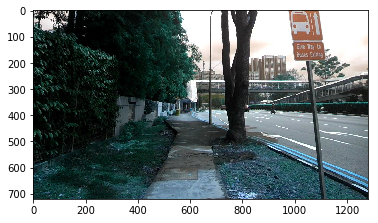

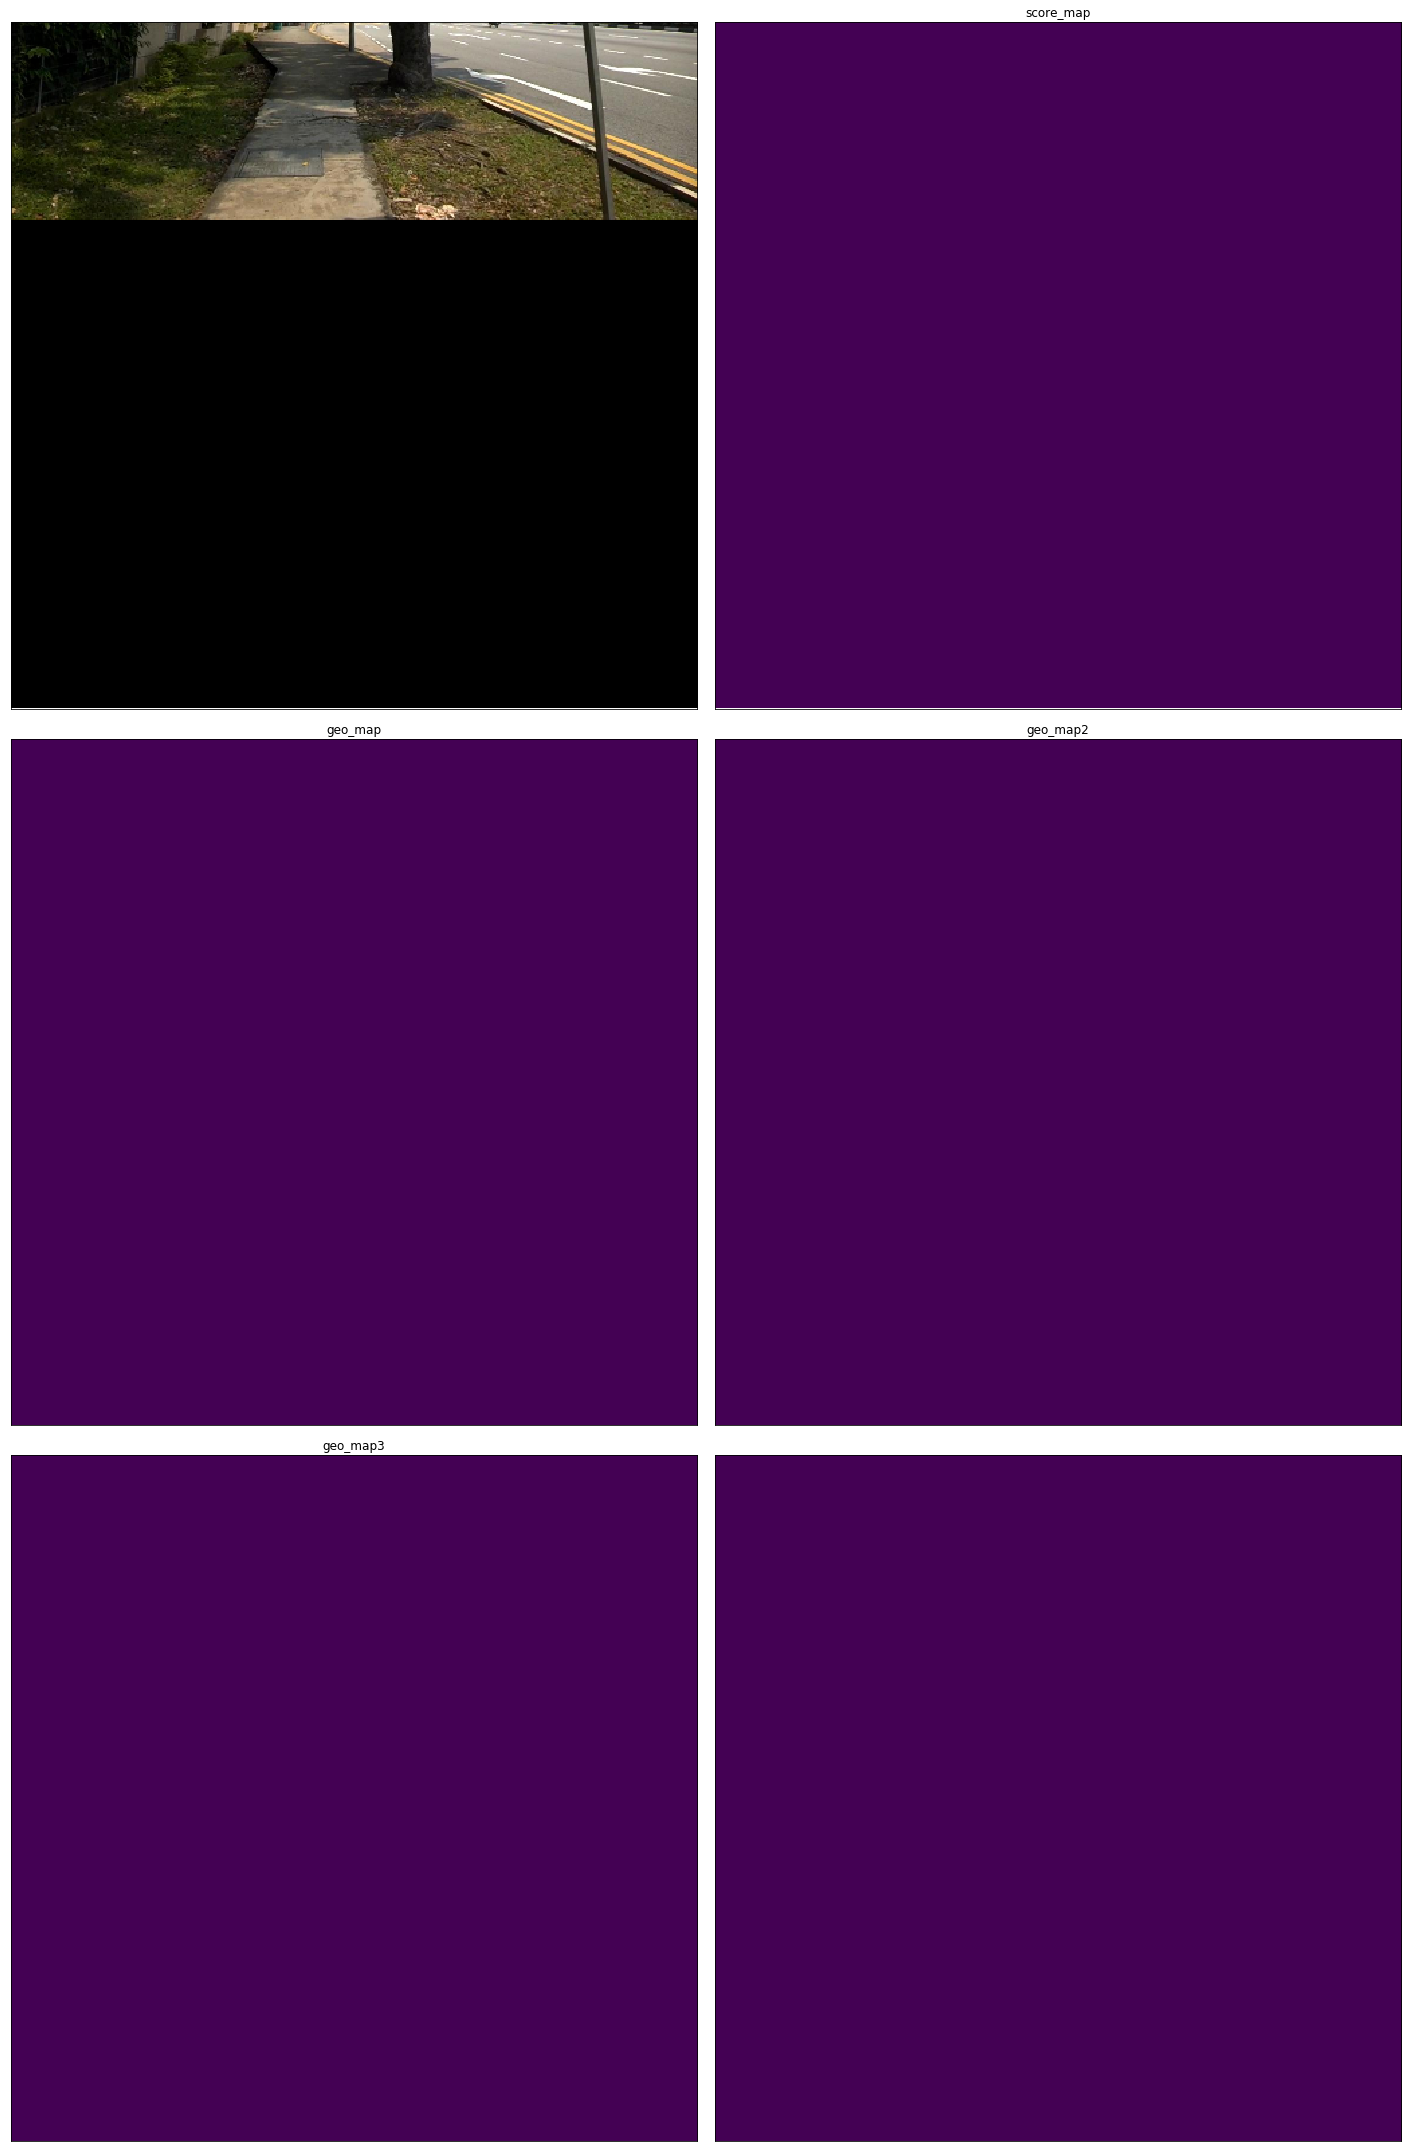

image (512, 512, 3)
score_map (128, 128, 1)
geo_map (128, 128, 5)
training_mask (128, 128, 1)


In [130]:
ret = image_2_data(image_file_path=images[54], geometry=geometry, vis=True)

In [138]:
ret[0].flatten()

array([9., 9., 7., ..., 0., 0., 0.], dtype=float32)